# Recurrent Neural Networks



In [1]:
import sys
sys.path.append("../../..")
import pandas as pd
import numpy as np
from pyadlml.dataset import set_data_home, fetch_uci_adl_binary
set_data_home('/home/chris/code/adlml/data_home')



subject = 'OrdonezB'
data = fetch_uci_adl_binary(cache=False, subject=subject)

/home/chris/Desktop/code/adlml/pyadlml/notebooks/models/sequential/../../../pyadlml/dataset/_core/devices.py:424: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results = np.array(list(dask.compute(*lazy_results)))
/home/chris/Desktop/code/adlml/pyadlml/notebooks/models/sequential/../../../pyadlml/dataset/_core/devices.py:464: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results = np.array(list(dask.compute(*dev_df_list)))


In [2]:
from pyadlml.model_selection import train_test_split

print('splitting data in train and test set...')
X_train, X_test, y_train, y_test, dev_pre_vals = train_test_split(
    data.df_devices,
    data.df_activities,
    #split='leave_one_day_out', 
    split=0.7,
    return_pre_vals=True)


splitting data in train and test set...


In [33]:
X_train.head(5)

,time,device,value
0,2012-11-11 21:14:21,Living Seat Pressure,True
1,2012-11-12 00:21:49,Living Seat Pressure,False
2,2012-11-12 00:22:57,Living Door PIR,True
3,2012-11-12 00:22:59,Living Door PIR,False
4,2012-11-12 00:23:14,Kitchen Door PIR,True


In [4]:
y_train.head(5)

,start_time,end_time,activity
0,2012-11-11 21:14:00,2012-11-12 00:22:59,Spare_Time/TV
1,2012-11-12 00:24:00,2012-11-12 00:43:59,Spare_Time/TV
2,2012-11-12 00:48:00,2012-11-12 00:49:59,Grooming
3,2012-11-12 00:50:00,2012-11-12 01:51:59,Spare_Time/TV
4,2012-11-12 01:52:00,2012-11-12 01:52:59,Grooming


In [5]:
dev_pre_vals

{'Bathroom Basin PIR': False,
 'Bathroom Shower PIR': False,
 'Bathroom Toilet Flush': False,
 'Bedroom Bed Pressure': False,
 'Bedroom Door PIR': False,
 'Entrance Maindoor Magnetic': False,
 'Kitchen Cupboard Magnetic': False,
 'Kitchen Door PIR': False,
 'Kitchen Fridge Magnetic': False,
 'Kitchen Microwave Electric': False,
 'Living Door PIR': False,
 'Living Seat Pressure': False}

## Define Pipeline

In [6]:
seq_type = 'many-to-many'
#seq_type = 'many-to-one'

In [7]:
from sklearn.base import TransformerMixin
class AddBatchDim(TransformerMixin):
    def fit(self, X, y):
        return self

    def fit_transform(self, X, y=None, **fit_params):
        return self.transform(X, y=y)

    def transform(self, X, y=None, **transform_params):
        import numpy as np
        return X[np.newaxis, ...]

In [8]:
from pyadlml.preprocessing import StateVectorEncoder, LabelEncoder, DropTimeIndex, CVSubset, SequenceSlicer, DfCaster
from pyadlml.pipeline import Pipeline, TrainOnlyWrapper, EvalOnlyWrapper, TrainOrEvalOnlyWrapper

steps = [
    ('encode_devices', StateVectorEncoder(encode='changepoint')),
    ('fit_labels', TrainOrEvalOnlyWrapper(LabelEncoder(idle=True))),
    ('drop_time', DropTimeIndex()),
    ('df->np', DfCaster('df->np', 'df->np')),
    ('batch', TrainOrEvalOnlyWrapper(SequenceSlicer(rep=seq_type, window_size=300, stride=3))),
    #('add', EvalOnlyWrapper(AddBatchDim())),
    ('passthrough', 'passthrough')
]

pipe = Pipeline(steps).train()

In [9]:
Xenc_train, yenc_train = pipe.fit_transform(X_train, y_train)

print('Xenc_train: ', type(Xenc_train), Xenc_train.shape, Xenc_train.dtype)
print('yenc_train: ', type(yenc_train), yenc_train.shape, yenc_train.dtype)

Xenc_train:  <class 'numpy.ndarray'> (989, 300, 12) float32
yenc_train:  <class 'numpy.ndarray'> (989, 300) int64


## Pytorch Implementation

In [13]:
import skorch
import torch
from skorch import NeuralNetClassifier
from pyadlml.dataset import TIME
import torch.nn as nn
import torch.nn.functional as F

use_cuda=False

In [14]:
class RNN(nn.Module):
    """
    
    Example for many-to-many and many-to-one relation
    # many-to-one           
        y torch.Size([1471])         -> torch.Size([1471])
        X torch.Size([1471, 20, 12]) -> torch.Size([1475, 11])

     # many-to-many
        y torch.Size([1471, 20]     -> torch.Size([29420])
        X torch.Size([1471, 20, 12] -> torch.Size([29420, 11])
    """
    def __init__(self, input_size, n_classes, rec_layer_type='lstm', 
                 hidden_size=300, hidden_layers=1, seq='many-to-one'):
        super().__init__()
        # set parameters for 
        self.input_size=input_size
        self.n_classes = n_classes
        self.hidden_size=hidden_size
        self.hidden_layers=hidden_layers
        self.rec_layer_type = rec_layer_type.lower()
        self.seq_type = seq
        
        self.reset_weights()
    
    def reset_weights(self):
        # initialize the weights
        rec_layer = {'lstm': nn.LSTM, 'gru': nn.GRU}[self.rec_layer_type]
        #input and ouput are providedd as (batch, seq, feature)
        self.rnn_ = rec_layer(self.input_size, 
                            hidden_size=self.hidden_size,
                            batch_first=True)
        self.out_ = nn.Linear(self.hidden_size, self.n_classes)
    
    def forward(self, x):
        seq_length = x.shape[1]
        
        # Initialize hidden state with zeros
        #h0 = torch.zeros(self.hidden_layers, x.size(0), self.hidden_size).requires_grad_()

        # Initialize cell state
        #c0 = torch.zeros(self.hidden_layers, x.size(0), self.hidden_size).requires_grad_()
        
        # forward pass through recurrent net
        if self.rec_layer_type == 'gru':
            out, _ = self.rnn_(x)
        elif self.rec_layer_type == 'lstm':
            # output (batch_size , seq length, hidden_size)
            # hn (n_layers, batch_size, hidden_size)
            # cn (n_layers, batch_size, hidden_size)
            #out, _ = self.rnn_(x, (h0, c0))        
            out, _ = self.rnn_(x)        
            
        # get either the whole latent state sequence or only the last
        if self.seq_type == 'many-to-one':
            # take output of last stacked RNN layer
            # Note: equiv to latent_rep = h_n[-1]  
            latent_rep = out[:,seq_length-1,:]
        else:
            latent_rep = out
            # todo flatten the array 
        out = F.softmax(self.out_(latent_rep), dim=-1)        

        return out

In [15]:
num_epochs = 100
learning_rate = 0.001 # 0.001 lr

input_size = 12    # number of features
num_classes = 11   # number of output classes 

hidden_size = 50   # number of features in hidden state
num_layers = 1     # number of stacked lstm layers


# define RNN, criterion as well as optimizer
rnn = RNN(input_size=input_size, n_classes=num_classes,
                  rec_layer_type='lstm', hidden_size=hidden_size, 
                  hidden_layers=1, seq=seq_type)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate) 

# Training
for epoch in range(num_epochs):
    outputs = rnn.forward(torch.Tensor(Xenc_train)) # forward pass
    optimizer.zero_grad() # calculate the gradient, manually setting to 0

    if seq_type == 'many-to-many':
        # flatten both tensors in order for the criterion to be applied
        outputs = torch.flatten(outputs, start_dim=0, end_dim=1)
        ys = torch.flatten(torch.LongTensor(yenc_train), start_dim=0, end_dim=1)
    else:
        ys = torch.LongTensor(yenc_train)
    # outputs (N, C), ys  (N)
    loss = criterion(outputs, ys) 
    
    # backpropagation
    loss.backward() 
    optimizer.step()
        
    if epoch % 10 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 2.39198
Epoch: 10, loss: 2.39067
Epoch: 20, loss: 2.37720
Epoch: 30, loss: 2.31101
Epoch: 40, loss: 2.24335
Epoch: 50, loss: 2.23110
Epoch: 60, loss: 2.23040
Epoch: 70, loss: 2.22724
Epoch: 80, loss: 2.22767
Epoch: 90, loss: 2.22785


In [16]:
pipe.eval()
transform_params = {'encode_devices__dev_pre_values': dev_pre_vals}

Xenc_test, yenc_test = pipe.transform(X_test, y_test, **transform_params)

print('Xenc_test: ', type(Xenc_test), Xenc_test.shape, Xenc_test.dtype)
print('yenc_test: ', type(yenc_test), yenc_test.shape, yenc_test.dtype)

Xenc_test:  <class 'numpy.ndarray'> (367, 300, 12) float32
yenc_test:  <class 'numpy.ndarray'> (367, 300) int64


In [17]:
with torch.no_grad():
    # predict with lstm
    outputs = rnn.forward(torch.Tensor(Xenc_test)) #forward pass 
    if seq_type == 'many-to-one':    
        y_pred = np.argmax(outputs.numpy(), axis=1)        
        y_true = torch.LongTensor(yenc_test).to_numpy()
    else:
        outputs = torch.flatten(outputs, start_dim=0, end_dim=1)
        y_pred = np.argmax(outputs.numpy(), axis=1)        
        y_true = torch.flatten(torch.LongTensor(yenc_test), start_dim=0, end_dim=1).numpy()

In [18]:
print('# classes: ', len(pipe['fit_labels'].wr.classes_))
print('y_true: ', type(y_true), y_true.shape, y_true.dtype)
print('y_pred: ', type(y_pred), y_pred.shape, y_pred.dtype)

# classes:  11
y_true:  <class 'numpy.ndarray'> (110100,) int64
y_pred:  <class 'numpy.ndarray'> (110100,) int64


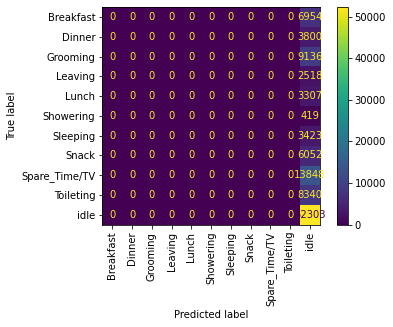

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred);

ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=pipe['fit_labels'].wr.classes_                       
                       )\
.plot(xticks_rotation='vertical');

In [20]:
from sklearn.metrics import classification_report
cr = classification_report(y_true, y_pred, 
                           target_names=pipe['fit_labels'].wr.classes_)

print(cr)

               precision    recall  f1-score   support

    Breakfast       0.00      0.00      0.00      6954
       Dinner       0.00      0.00      0.00      3800
     Grooming       0.00      0.00      0.00      9136
      Leaving       0.00      0.00      0.00      2518
        Lunch       0.00      0.00      0.00      3307
    Showering       0.00      0.00      0.00       419
     Sleeping       0.00      0.00      0.00      3423
        Snack       0.00      0.00      0.00      6052
Spare_Time/TV       0.00      0.00      0.00     13848
    Toileting       0.00      0.00      0.00      8340
         idle       0.48      1.00      0.64     52303

     accuracy                           0.48    110100
    macro avg       0.04      0.09      0.06    110100
 weighted avg       0.23      0.48      0.31    110100



/home/chris/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chris/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chris/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# RNN with Skorch

To get a pipeline ready model we use skorch. 
<hr>
Only have to modify the loss classifiers function:

In [21]:
from skorch.utils import to_tensor
from skorch.utils import TeeGenerator
class RNNClassifier(NeuralNetClassifier):
    def __init__(self, *args, batch_size=1, train_split=None,**kwargs):
            super().__init__(*args, batch_size=batch_size, train_split=train_split, **kwargs)
    
    def get_loss(self, y_pred, y_true, X=None, training=False):
        """Return the loss for this batch.
        Parameters
        ----------
        y_pred : torch tensor
          Predicted target values
        y_true : torch tensor
          True target values.
        X : input data, compatible with skorch.dataset.Dataset
        """
        if self.module_.seq_type == 'many-to-many':
            y_true = torch.flatten(to_tensor(y_true, device=self.device), start_dim=0, end_dim=1)
            y_pred = torch.flatten(y_pred, start_dim=0, end_dim=1)
        
        elif self.module_.seq_type != 'many-to-one':
            ValueError("the sequence type of the RNN was false defined")
        
        if isinstance(self.criterion_, torch.nn.Module):
            self.criterion_.train(training)
        
        return self.criterion_(y_pred, y_true)

and define the model 

In [25]:
# Training params
max_epochs = 10
learning_rate = 0.001 # 0.001 lr
batch_size=2


# RNN Params
input_size = 12    # number of features
hidden_size = 10   # number of features in hidden state
num_layers = 2     # number of stacked lstm layers
num_classes = 11   # number of output classes 
rec_layer_type = 'lstm'
hidden_layers=1
seq_type='many-to-many'


model = RNNClassifier(
    module=RNN,
    max_epochs=max_epochs,
    #batch_size=1,
    #train_split=None,
    device=('cuda' if use_cuda else 'cpu'),
    lr=learning_rate,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    callbacks=[skorch.callbacks.ProgressBar()],
    module__input_size=input_size,
    module__n_classes=num_classes,
    module__hidden_size=hidden_size,
    module__rec_layer_type=rec_layer_type,
    module__seq=seq_type,
    iterator_train__shuffle=True, # TODO TEST THIS
)

In [26]:
Xenc_train.shape, yenc_train.shape

((989, 300, 12), (989, 300))

In [27]:
model = model.fit(Xenc_train, yenc_train)

  0%|          | 0/989 [00:00<?, ?it/s]

  epoch    train_loss      dur
-------  ------------  -------
      1        2.2155  81.9286


  0%|          | 0/989 [00:00<?, ?it/s]

      2        2.1067  83.8594


  0%|          | 0/989 [00:00<?, ?it/s]

      3        1.9569  82.2977


  0%|          | 0/989 [00:00<?, ?it/s]

      4        1.9049  85.9134


  0%|          | 0/989 [00:00<?, ?it/s]

      5        1.8917  83.3628


  0%|          | 0/989 [00:00<?, ?it/s]

      6        1.8824  82.5277


  0%|          | 0/989 [00:00<?, ?it/s]

      7        1.8743  82.8012


  0%|          | 0/989 [00:00<?, ?it/s]

      8        1.8673  84.6639


  0%|          | 0/989 [00:00<?, ?it/s]

      9        1.8608  83.5099


  0%|          | 0/989 [00:00<?, ?it/s]

     10        1.8531  83.6879


In [28]:
y_pred_proba = model.predict_proba(Xenc_test)
y_pred_proba.shape

(367, 300, 11)

In [32]:
yenc_test[0], np.argmax(y_pred_proba[0]), y_pred_proba[0],

(array([10,  8,  8,  8,  8,  8,  8,  8,  8,  8, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10,  2,  2,  5,  5,  2,  2, 10, 10, 10, 10,
        10, 10, 10, 10,  8,  8,  8,  8,  8,  8, 10, 10, 10, 10, 10, 10, 10,
        10,  3,  3,  3,  3, 10, 10, 10, 10,  8,  8,  8,  8,  8,  8, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,
        10, 10, 10, 10, 10, 10,  2,  2,  2,  2,  9,  9,  2,  2, 10, 10, 10,
        10,  3,  3,  3,  3,  3,  3, 10, 10, 10, 10,  2,  2,  2,  2, 10, 10,
        10, 10,  9,  9,  9,  9,  9,  9,  9,  9,  6,  6,  6,  6,  9,  9,  9,
         9, 10, 10, 10, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  2,  2,  2,  2, 10, 10, 10, 10,  2,  2,  9,
         9,  2,  2, 10, 10, 10, 10, 10, 10, 10, 10,  8,  8,  8,  8,  8,  8,
        10, 10, 10, 10, 10, 10, 10, 10,  8,  8,  8,  8,  8,  8,  3,  3,  3,
         3, 

In [30]:
y_pred = model.predict(Xenc_test) # applies argmax over last axis from predict_proba
y_pred.shape

(367, 11)

In [31]:
yenc_test[0], y_pred[0]

(array([10,  8,  8,  8,  8,  8,  8,  8,  8,  8, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10,  2,  2,  5,  5,  2,  2, 10, 10, 10, 10,
        10, 10, 10, 10,  8,  8,  8,  8,  8,  8, 10, 10, 10, 10, 10, 10, 10,
        10,  3,  3,  3,  3, 10, 10, 10, 10,  8,  8,  8,  8,  8,  8, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,
        10, 10, 10, 10, 10, 10,  2,  2,  2,  2,  9,  9,  2,  2, 10, 10, 10,
        10,  3,  3,  3,  3,  3,  3, 10, 10, 10, 10,  2,  2,  2,  2, 10, 10,
        10, 10,  9,  9,  9,  9,  9,  9,  9,  9,  6,  6,  6,  6,  9,  9,  9,
         9, 10, 10, 10, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  2,  2,  2,  2, 10, 10, 10, 10,  2,  2,  9,
         9,  2,  2, 10, 10, 10, 10, 10, 10, 10, 10,  8,  8,  8,  8,  8,  8,
        10, 10, 10, 10, 10, 10, 10, 10,  8,  8,  8,  8,  8,  8,  3,  3,  3,
         3, 

In [51]:
y_pred.shape, yenc_test.shape

((367,), (367,))

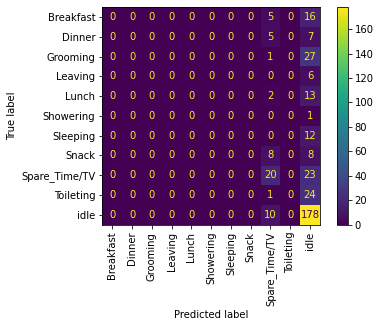

In [52]:
cm = confusion_matrix(yenc_test, y_pred);

ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=pipe['fit_labels'].wr.classes_)\
.plot(xticks_rotation='vertical');

In [53]:
cr = classification_report(yenc_test, y_pred, target_names=pipe['fit_labels'].wr.classes_)

print(cr)

               precision    recall  f1-score   support

    Breakfast       0.00      0.00      0.00        21
       Dinner       0.00      0.00      0.00        12
     Grooming       0.00      0.00      0.00        28
      Leaving       0.00      0.00      0.00         6
        Lunch       0.00      0.00      0.00        15
    Showering       0.00      0.00      0.00         1
     Sleeping       0.00      0.00      0.00        12
        Snack       0.00      0.00      0.00        16
Spare_Time/TV       0.38      0.47      0.42        43
    Toileting       0.00      0.00      0.00        25
         idle       0.57      0.95      0.71       188

     accuracy                           0.54       367
    macro avg       0.09      0.13      0.10       367
 weighted avg       0.33      0.54      0.41       367



/home/chris/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chris/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chris/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Grid search

In [54]:
# when the input shape changes we want to set it dynamically

class InputShapeSetter(skorch.callbacks.Callback):
    def on_train_begin(self, net, X, y):
        net.set_params(module__input_size=X.shape[2])

In [59]:
from pyadlml.model_selection import GridSearchCV, TimeSeriesSplit
from pyadlml.preprocessing import StateVectorEncoder, LabelEncoder, DropTimeIndex, CVSubset, SequenceSlicer, Df2Numpy, Df2Torch
from pyadlml.pipeline import Pipeline, TrainOnlyWrapper, EvalOnlyWrapper, TrainOrEvalOnlyWrapper

input_size = 20
num_classes = 12
max_epochs = 10

classifier = RNNClassifier(module=RNN,
    max_epochs=max_epochs,
    device=('cuda' if use_cuda else 'cpu'),
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,    
    module__input_size=input_size,
    module__n_classes=num_classes,
    module__seq='many-to-one',
    callbacks=[InputShapeSetter()]
)
steps=[
   ('sv_enc', StateVectorEncoder()),
    ('lbl_enc', TrainOrEvalOnlyWrapper(LabelEncoder(idle=True))),
    ('select_train', TrainOnlyWrapper(CVSubset())),
    ('select_val', EvalOnlyWrapper(CVSubset())),
    ('drop_time', DropTimeIndex()),
    ('df->np', DfCaster('df->np', 'df->np')),
    ('batcher', TrainOrEvalOnlyWrapper(SequenceSlicer(rep=seq_type, stride=3))),
   #('dim_fix', ProdOnlyWrapper(AddBatchDim())),
    ('classifier', classifier),
]
    
pipe = Pipeline(steps).train()


param_grid = {
    'sv_enc__encode': ['changepoint', 'raw+changepoint'],
    'batcher__wr__window_size': [100,300],
    #'batcher__wr__stride': [1,5,20],
    #'classifier__lr': [0.001, 0.01, 0.1],
    #'classifier__module__hidden_size': [20,100, 30],
    #'classifier__module__rec_layer_type': ['lstm', 'gru'],
    
}

In [60]:
ts = TimeSeriesSplit()

gscv = GridSearchCV(
    online_train_val_split=True,
    estimator=pipe,
    param_grid=param_grid,
    scoring=['accuracy'],
    verbose=1,
    refit=True,
    n_jobs=8,
    cv=ts
)

In [61]:
gscv = gscv.fit(X_train, y_train)
print('report: ', gscv.cv_results_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
report:  {'mean_fit_time': array([327.4951015 , 349.02462339, 310.02911925, 264.32844663]), 'std_fit_time': array([131.27117057, 178.26092279, 114.94021226,  71.90174177]), 'mean_score_time': array([7.68317513, 7.38647237, 6.42873378, 4.2857058 ]), 'std_score_time': array([0.17519425, 1.75292245, 2.65913357, 2.03981355]), 'param_batcher__wr__window_size': masked_array(data=[100, 100, 300, 300],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_sv_enc__encode': masked_array(data=['changepoint', 'raw+changepoint', 'changepoint',
                   'raw+changepoint'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'batcher__wr__window_size': 100, 'sv_enc__encode': 'changepoint'}, {'batcher__wr__window_size': 100, 'sv_enc__encode': 'raw+changepoint'}, {'batcher__wr__window_size': 300, 'sv_enc__encode': 'changepoint

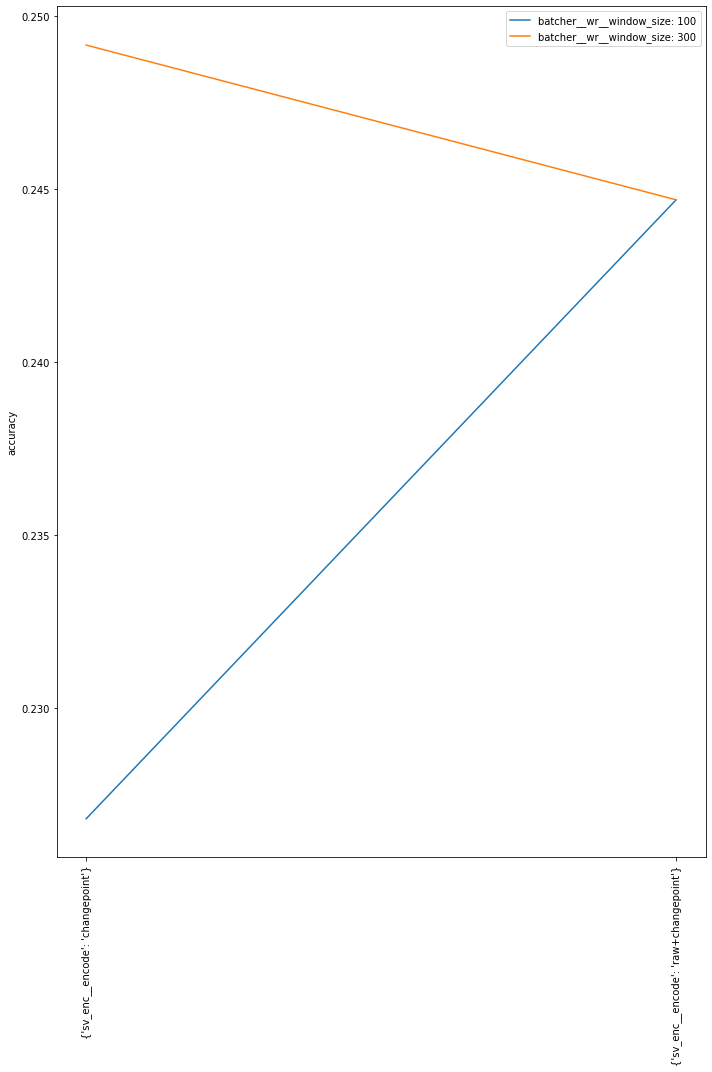

In [64]:
from pyadlml.plot import plot_cv_impact_parameter
plot_cv_impact_parameter(gscv, 'batcher__wr__window_size')